In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

# Load the dataset (replace with your actual file path)
df = pd.read_excel("C:\\Users\\mukil\\OneDrive - University of Southampton\\GDP - COMP6200\\CVD's Dataset.xlsx")

# Step 1: Handling Missing Values
# Impute missing values for numeric columns with mean and categorical columns with mode
numeric_columns = ['cigsPerDay', 'sysBP', 'diaBP', 'BMI', 'heartRate']
categorical_columns = ['education']

imputer_num = SimpleImputer(strategy='mean')
imputer_cat = SimpleImputer(strategy='most_frequent')

df[numeric_columns] = imputer_num.fit_transform(df[numeric_columns])
df[categorical_columns] = imputer_cat.fit_transform(df[categorical_columns])

# Step 2: Encoding Categorical Variables (Binary variables)
binary_columns = ['male', 'currentSmoker', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes']
label_encoder = LabelEncoder()
df[binary_columns] = df[binary_columns].apply(label_encoder.fit_transform)

# Step 3: Feature Scaling (Standardizing numeric features)
scaler = StandardScaler()
scaled_columns = ['sysBP', 'diaBP', 'BMI', 'heartRate']
df[scaled_columns] = scaler.fit_transform(df[scaled_columns])

# Step 4: Splitting the Dataset into Features (X) and Target (y)
X = df.drop(columns=['TenYearCHD'])  # Features
y = df['TenYearCHD']  # Target

# Step 5: Train-Test Split (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to oversample CVD cases
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Training set shape:", X_train_smote.shape)
print("Test set shape:", X_test.shape)

Training set shape: (5742, 13)
Test set shape: (848, 13)


Accuracy before tuning: 0.7901
ROC AUC before tuning: 0.6048

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       725
           1       0.19      0.14      0.16       123

    accuracy                           0.79       848
   macro avg       0.53      0.52      0.52       848
weighted avg       0.76      0.79      0.78       848



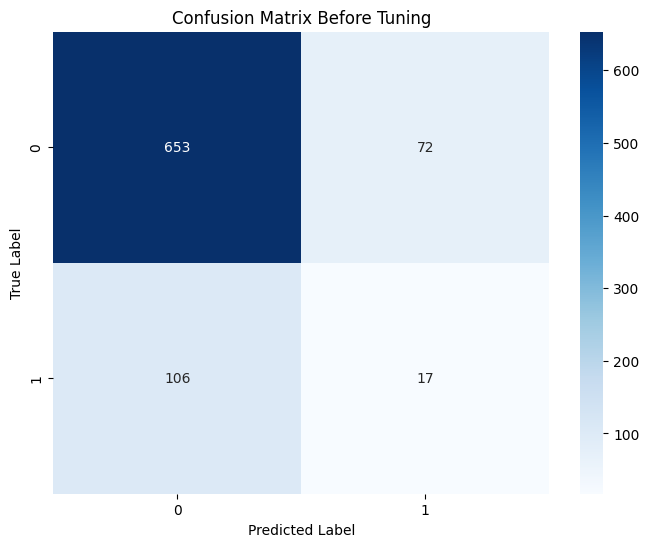

In [2]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize XGBoost model with default parameters
xgb_model_before_tuning = XGBClassifier(random_state=42)

# Train the model on the SMOTE-balanced dataset
xgb_model_before_tuning.fit(X_train_smote, y_train_smote)

# Make predictions on the test set
y_pred_before_tuning = xgb_model_before_tuning.predict(X_test)
y_pred_proba_before_tuning = xgb_model_before_tuning.predict_proba(X_test)[:, 1]

# Evaluate the model performance before tuning
accuracy_before_tuning = accuracy_score(y_test, y_pred_before_tuning)
roc_auc_before_tuning = roc_auc_score(y_test, y_pred_proba_before_tuning)

print(f"Accuracy before tuning: {accuracy_before_tuning:.4f}")
print(f"ROC AUC before tuning: {roc_auc_before_tuning:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_before_tuning))

# Plot confusion matrix before tuning
plt.figure(figsize=(8, 6))
cm_before_tuning = confusion_matrix(y_test, y_pred_before_tuning)
sns.heatmap(cm_before_tuning, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix Before Tuning')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [3]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for tuning
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
    'min_child_weight': [1, 3],
    'gamma': [0.0, 0.1],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9],
    'scale_pos_weight': [1]  # Adjust based on class imbalance if needed
}

# Initialize XGBoost model for tuning
xgb_model_after_tuning = XGBClassifier(random_state=42)

# Set up GridSearchCV with k-fold cross-validation (cv=5)
grid_search = GridSearchCV(estimator=xgb_model_after_tuning,
                           param_grid=param_grid,
                           scoring='roc_auc',
                           cv=5,
                           verbose=2,
                           n_jobs=-1)

# Fit grid search to the training data (SMOTE-balanced)
grid_search.fit(X_train_smote, y_train_smote)

# Get the best parameters from grid search
best_params = grid_search.best_params_
best_xgb_model_after_tuning = grid_search.best_estimator_

print("Best parameters found:", best_params)

Fitting 5 folds for each of 192 candidates, totalling 960 fits
Best parameters found: {'colsample_bytree': 0.9, 'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 200, 'scale_pos_weight': 1, 'subsample': 0.9}


C:\Users\mukil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Accuracy after tuning: 0.7866
ROC AUC after tuning: 0.6282

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.89      0.88       725
           1       0.22      0.19      0.20       123

    accuracy                           0.79       848
   macro avg       0.54      0.54      0.54       848
weighted avg       0.77      0.79      0.78       848



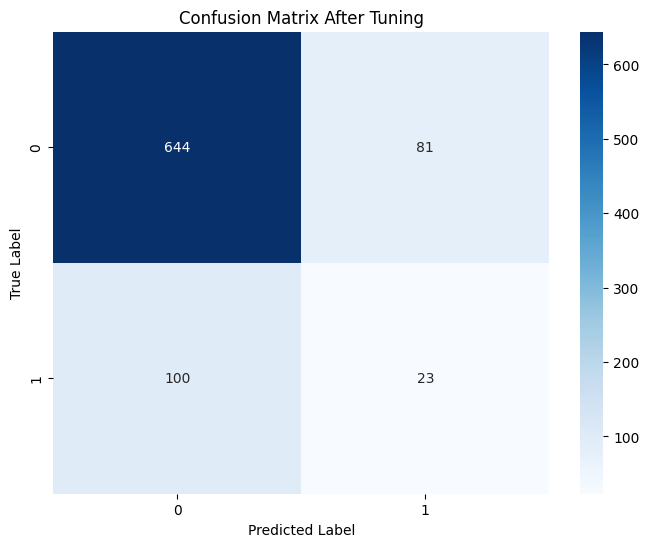


Model Comparison:
Accuracy before tuning: 0.7901
Accuracy after tuning : 0.7866
ROC AUC before tuning : 0.6048
ROC AUC after tuning  : 0.6282


In [4]:
# Make predictions on the test set using the tuned model
y_pred_after_tuning = best_xgb_model_after_tuning.predict(X_test)
y_pred_proba_after_tuning = best_xgb_model_after_tuning.predict_proba(X_test)[:, 1]

# Evaluate the model performance after tuning
accuracy_after_tuning = accuracy_score(y_test, y_pred_after_tuning)
roc_auc_after_tuning = roc_auc_score(y_test, y_pred_proba_after_tuning)

print(f"Accuracy after tuning: {accuracy_after_tuning:.4f}")
print(f"ROC AUC after tuning: {roc_auc_after_tuning:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_after_tuning))

# Plot confusion matrix after tuning
plt.figure(figsize=(8, 6))
cm_after_tuning = confusion_matrix(y_test, y_pred_after_tuning)
sns.heatmap(cm_after_tuning, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix After Tuning')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Compare results before and after tuning
print("\nModel Comparison:")
print(f"Accuracy before tuning: {accuracy_before_tuning:.4f}")
print(f"Accuracy after tuning : {accuracy_after_tuning:.4f}")
print(f"ROC AUC before tuning : {roc_auc_before_tuning:.4f}")
print(f"ROC AUC after tuning  : {roc_auc_after_tuning:.4f}")

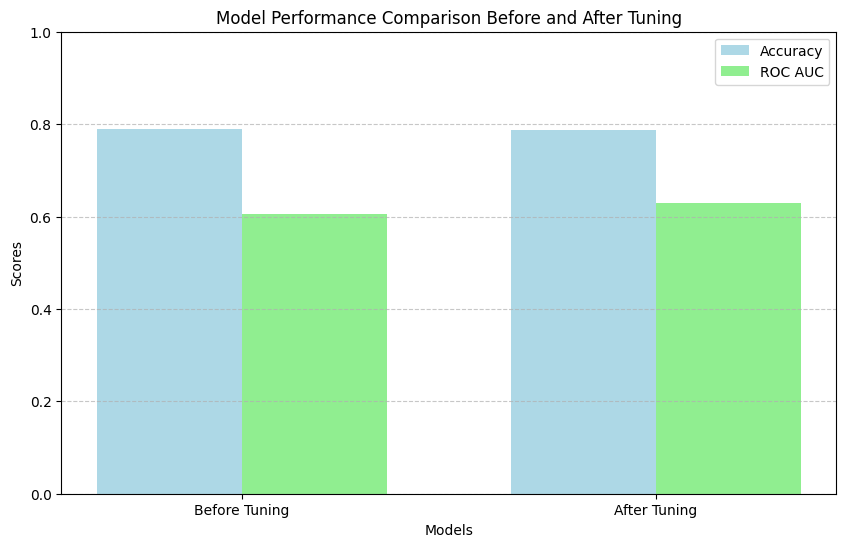

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics for model performance before and after tuning
models = ['Before Tuning', 'After Tuning']
accuracy = [0.7901, 0.7866]
roc_auc = [0.6048, 0.6282]

# Create an array for X-axis positions
x = np.arange(len(models))

# Set width of bars
width = 0.35

# Create the bar plot
fig, ax = plt.subplots(figsize=(10, 6))

# Bar plots for Accuracy and ROC AUC
bars1 = ax.bar(x - width/2, accuracy, width, label='Accuracy', color='lightblue')
bars2 = ax.bar(x + width/2, roc_auc, width, label='ROC AUC', color='lightgreen')

# Add labels, title, and custom x-axis tick labels
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison Before and After Tuning')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Add grid lines for better readability
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the bar plot
plt.show()
